In [1]:
#imports
import sys
import subprocess 
import scipy.constants as con
import scipy.optimize as opt
import importlib
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
import scipy.linalg as la
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
import time
import matplotlib.pyplot as plt
import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

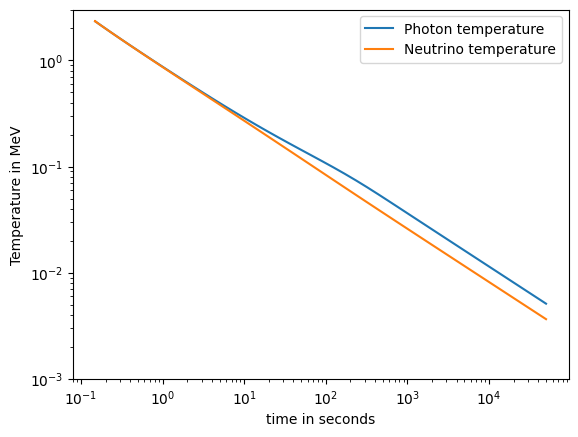

In [2]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV


def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

T_ini=27/TMeV2T9                     #initial temperature in MeV

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV


z_ini=e_mass/T_ini

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h



rho_b_ini=M_u*eta_ini*n_gamma_ini    #initial baryon density

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(a):
    return rho_b_ini/a**3

def P_b(T,a):
    return T*eta_ini*n_gamma_ini/a**3

#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)+P_b(T,a)))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)


#Derivatives for Jacobian

def dadT(T,a):
    return -((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)+P_b(T,a)))*a/3

def drho_nu(T,a): #neutrina energy density
    return -rho_nu_ini*4/a**5

def drho_b(T,a):
    return -h_ini*T_ini**3*3/a**4

def rho_totdT(T,a): #total density
    return drho_e(T)+drho_gamma(T)+(drho_nu(T,a))#+drho_b(T,a))*dadT(T,a)

def rho_totda(T,a): #total density
    return (drho_e(T)+drho_gamma(T))/dadT(T,a)+drho_nu(T,a)#+drho_b(T,a)



def HdT(T,a):   #Hubble parameter deriv with respect to Temperature
    return 4*np.pi/3*G*rho_totda(T,a)/H(T,a)

def Hda(T,a):   #Hubble parameter deriv with respect to Scale factor
    return 4*np.pi/3*G*rho_totdT(T,a)/H(T,a)

def dadtda(t,T,a):
    return H(T,a)+a*Hda(T,a)


def dadtdT(t,T,a):
    return dadT(T,a)*H(T,a)+a*HdT(T,a)



t_range=[t_ini,5e4*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[1], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure


n_bparams=2


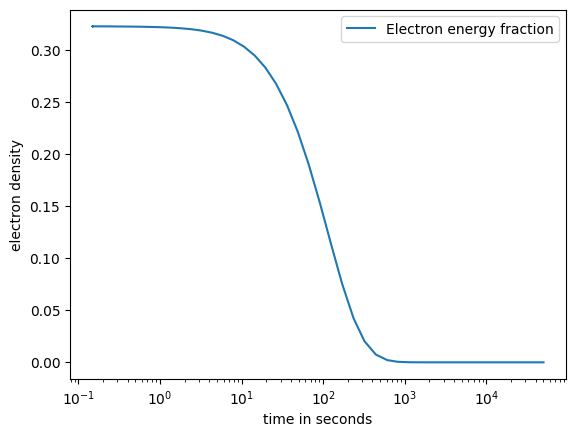

In [3]:
plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, [rho_e(T)/rho_tot(T,a) for T,a in sol.y.T], label='Electron energy fraction')

#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('electron density')

plt.xscale('log')
#plt.yscale('log')

# plt.xlim((0.1, 2e5))
#plt.ylim((1e-20,3))

plt.legend()
plt.show()

#plt.figure

In [4]:
#import networks

#section for AoT compilation of network
import H2_AoT_net as bbn_H2
import He4_AoT_net as bbn_He4
import AoT_net as bbn_n
import full_AoT_net as bbn_full
networks=[bbn_n,bbn_full]
#number of nuclei in network, nNucs[-1]=2 to since initial condition sets n and p
nNucs=[net.nnuc() for net in networks]+[2]

#times for switching between networks
t_start=[t_ini,timeunit,1e5*timeunit]


In [5]:
#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]

fnNucs=nNucs[-2]

A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8.])
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])
#print([label for _, label in sorted(zip(A, Y_labels))])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
spin=PNAsort(Alterspin)

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]
m_Nucs = np.array(PNAsort(Alter_mass))
m_n,m_p,m_d,m_t,m_He3,m_He4=m_Nucs[:6]

def rho_bY_cgs(y):
    return sum(m_Nucs[:len(y[n_bparams:])]*y[n_bparams:])*eta_ini*n_gamma_ini/y[1]**3*gcm3


B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
g = 1+2*np.array(spin)

print(Alter_Yl)
print(Altersort(Y_labels))

print(Y_labels)
print(PNAsort(Alter_Yl))

['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']


In [6]:
#Functions for determining additional abundances for each network

#Initial conditions from thermal equilibrium
def get_Y_thermal(Y,n,T):
    Y_2 = np.zeros(n)
    Y_2[:len(Y)] = Y
    for i in range(len(Y),n):
        tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
        Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]

    return Y_2

def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x

#Initial conditions from Jacobian
def get_Y_jac(y,i):

    AdYdt_cut=lambda Y : Altersort(networks[i].rhs(0, PNAsort(Y) ,rho_bY_cgs(list(y[:n_bparams])+list(PNAsort(Y))), y[0]*TMeV2T9*1e9))
    AdYdt_jac_cut=lambda Y : networks[i].jacobian(0, PNAsort(Y) ,rho_bY_cgs(list(y[:n_bparams])+list(PNAsort(Y))), y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
    aY_cut=Altersort(get_Y_thermal(y[n_bparams:][:nNucs[i-1]],nNucs[i],y[0]))

    Yj = np.array([YY for YY in aY_cut])
    
    
    for cut in range(nNucs[i-1], len(Yj) - 2, 1):
        for j in range(10):
            fyj = -AdYdt_cut(Yj)
            jac = AdYdt_jac_cut(Yj)
            if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                print('Yj:', Yj)
                raise ValueError
            if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                print('Yj:', Yj)
                print('fyj:', fyj)
                raise ValueError
            # Implement cut:
            fyj = fyj[cut:]
            jac = jac[cut:, cut:]
            
            # Solution using SVD
            U, s, Vh = la.svd(jac)    
            x = solve_using_svd(U, s, Vh, fyj)
            for k in range(1):
                #A · δx = A · (x + δx) − b
                residuals = jac @ x - fyj
                dx = solve_using_svd(U, s, Vh, residuals)
                x -= dx
            Yj[cut:] += x
    return list(y[:n_bparams])+list(PNAsort(Yj))

In [7]:
#Solve the system
#initial conditions

solY=np.array([[T_ini],[1],[1/(np.exp(Q/T_ini)+1)],[1/(np.exp(-Q/T_ini)+1)]])
soltime=np.array([t_ini])
derivtime=0
jactime=0
backgroundtime=0
rhotime=0

for i in range(len(networks)):


    initial_param=get_Y_jac(solY[:,-1],i)
    n_params=nNucs[i]+n_bparams
    
    #Give PyNucAstro jacobian nessecary parameters
    def jacPNA(t,y):
        return networks[i].jacobian(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit

    #Extend Jacobian with background parameters
    def jacobian(t,y):
        global jactime
        tid=time.time()
        jac=np.append(np.zeros((nNucs[i],n_bparams)),jacPNA(t,y),axis=1)
        jactime+=time.time()-tid
        return np.append(np.zeros((n_bparams,n_params)),jac,axis=0)

    #full derivative
    def dydt(t,y): 
        global derivtime      
        global backgroundtime
        global rhotime
        tid=time.time()
        1+1
        rhotime+=time.time()-tid
        tid=time.time()
        result=dbackground(t,y[:n_bparams])
        backgroundtime+=time.time()-tid
        tid=time.time()
        result+=list( networks[i].rhs(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit)      
        derivtime+=time.time()-tid

        return result

    jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-6,jac=jacobian)#,t_eval=t_space)

    abun=[abun[-1] for abun in jacsolY.y[n_bparams:]]

    solY=np.concatenate((np.concatenate((solY,np.multiply(np.ones((len(solY[0]),nNucs[i]-nNucs[i-1])),initial_param[len(solY):]).T)),jacsolY.y),axis=1)

    soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))


In [8]:
print(backgroundtime)
print(derivtime)
print(jactime)
print(rhotime)
print(backgroundtime+derivtime+jactime)


4.655876398086548
0.5097570419311523
0.053354501724243164
0.0036745071411132812
5.218987941741943


In [9]:
#solving with full network



final_abun=[fabun[-1] for fabun in solY[n_bparams:]]


print([final_abun[0],final_abun[1],2*final_abun[2],3*final_abun[3],3*final_abun[4],4*final_abun[5]])
print('sum: ', sum(np.array(final_abun)*A[:fnNucs]))

[8.161552034480224e-12, 0.7526613768786098, 3.78115449608316e-05, 1.8346025536094544e-07, 2.3220751967639142e-05, 0.24727740484617505]
sum:  1.000000000002153


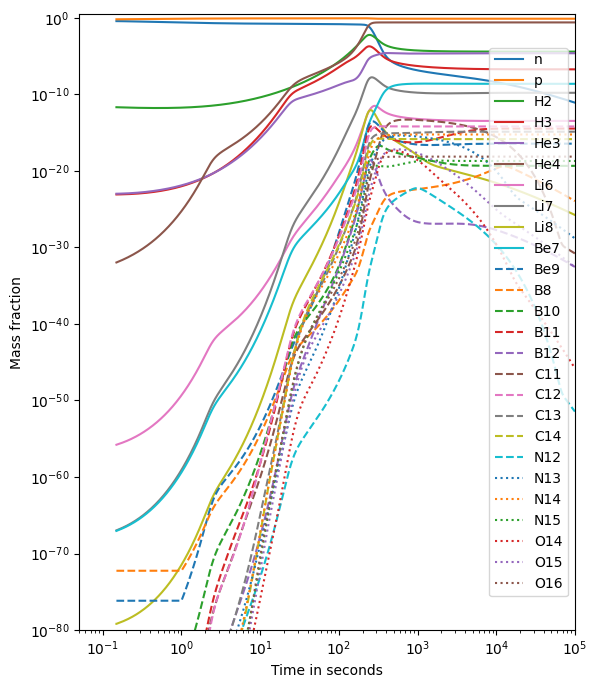

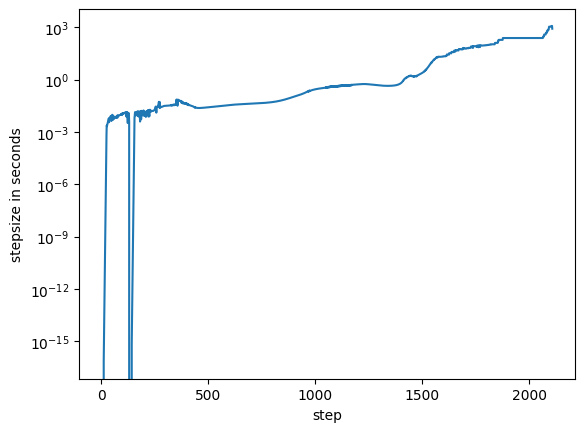

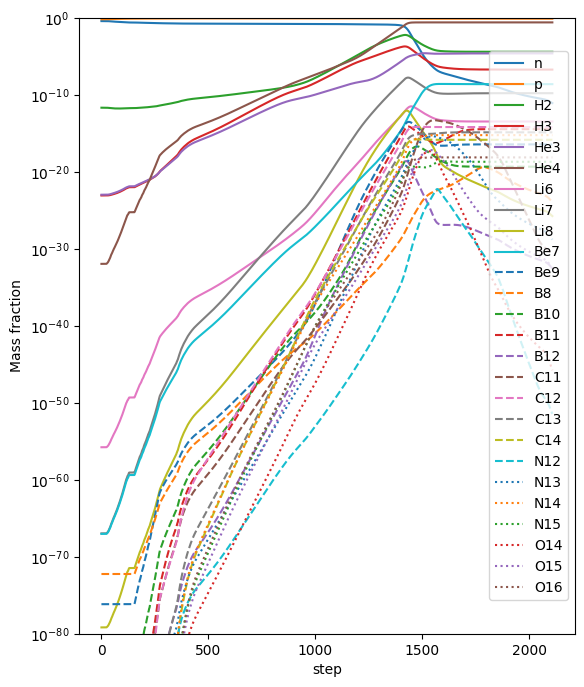

In [10]:
# Plot the results    


plt.figure('abundance',figsize=(6.4, 8))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=3
line=['-']*10+['--']*10+[':']*10
for i in range(fnNucs):
    plt.plot(soltime/timeunit, A[i]*solY[n_bparams+i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('Time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,3)
plt.xlim(t_ini/timeunit/3,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center right')
plt.show()

plt.figure('step size')
plt.plot(range(len(soltime)),[(soltime[i]-soltime[i-1])/timeunit for i in range(len(soltime))] )
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('stepsize in seconds')
plt.show()

plt.figure('abundance',figsize=(6.4, 8))

for i in range(fnNucs):
      plt.plot(range(len(soltime)), A[i]*solY[n_bparams+i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('step')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,1)
#plt.xlim(0,20)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()

In [11]:
print(' ')
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')
abun=final_abun
print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


 
Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.473e-01	 2.512e-05	 1.037e-05	 4.768e-10	 7.452e-15	 4.468e-10


In [12]:
def n_p__d(T9):
    # n + p --> d
    rate = 0.0
    T913=T9**(1/3)
    T953=T9**(5/3)
    lnT9=np.log(T9)
    # an06n
    rate += np.exp(  12.3687 + -2.70618*T913
                  + 0.11718*T9 + -0.00312788*T953 + 0.469127*lnT9)
    # an06n
    rate += np.exp(  10.7548 + -2.30472*T913 + -0.887862*T9 + 0.137663*T953)
    # an06n
    rate += np.exp(  8.84688 + -0.0102082*T913  + -0.0893959*T9 + 0.00696704*T953 + 1.0*lnT9)

    return rate

def Alter_n_p__d(T9):
    if(T9<=1.5):
        res=44216.*(1+3.75191*T9+1.92934*T9*T9+0.746503*T9*T9*T9+0.0197023*pow(T9,4.)+3.00491e-6*pow(T9,5.))/(1+5.4678*T9+5.62395*T9*T9+0.489312*T9*T9*T9+0.00747806*pow(T9,4.))
    else:
        res=(1.-np.sqrt(T9)*0.8504+T9*0.4895-pow(T9,3./2.)*0.09623+T9*0.008471*T9-T9*2.8e-4*pow(T9,3./2.))*47420.
    return res

def Reaclib_d_p__He3(T9): #H2 + p -> g + He3
    rate = 0.0
    T913=T9**(1/3)
    T913i=1/T913
    lnT9=np.log(T9)

    # de04 
    rate += np.exp(  8.93525 + -3.7208*T913i + 0.198654*T913
                  + 0.333333*lnT9)
    # de04n
    rate += np.exp(  7.52898 + -3.7208*T913i + 0.871782*T913
                  + -0.666667*lnT9)

    return rate


def Alter_d_p__He3(T9): #H2 + p -> g + He3
        if (T9<0.001): res==4.815e-14
        elif ((T9>=0.001)and(T9<=0.0015)): res=4.815e-14
        elif ((T9>0.0015)and(T9<=0.0025)): res=6.409e-9
        elif ((T9>0.0025)and(T9<=0.0035)): res=4.525e-7
        elif ((T9>0.0035)and(T9<=0.0045)): res=4.896e-6
        elif ((T9>0.0045)and(T9<=0.0055)): res=2.444e-5
        elif ((T9>0.0055)and(T9<=0.0065)): res=8.086e-5
        elif ((T9>0.0065)and(T9<=0.0075)): res=2.078e-4
        elif ((T9>0.0075)and(T9<=0.0085)): res=4.499e-4
        elif ((T9>0.0085)and(T9<=0.0095)): res=8.619e-4
        elif ((T9>0.0095)and(T9<=0.0105)): res=1.506e-3
        elif ((T9>0.0105)and(T9<=0.0115)): res=2.450e-3
        elif ((T9>0.0115)and(T9<=0.0125)): res=3.767e-3
        elif ((T9>0.0125)and(T9<=0.0135)): res=5.531e-3
        elif ((T9>0.0135)and(T9<=0.0145)): res=7.816e-3
        elif ((T9>0.0145)and(T9<=0.0155)): res=1.070e-2
        elif ((T9>0.0155)and(T9<=0.0170)): res=1.425e-2
        elif ((T9>0.0170)and(T9<=0.0190)): res=2.366e-2
        elif ((T9>0.0190)and(T9<=0.0225)): res=3.659e-2
        elif ((T9>0.0225)and(T9<=0.0275)): res=8.753e-2
        elif ((T9>0.0275)and(T9<=0.0350)): res=1.701e-1
        elif ((T9>0.035)and(T9<=0.045)): res=4.476e-1
        elif ((T9>0.045)and(T9<=0.055)): res=8.915e-1
        elif ((T9>0.055)and(T9<=0.065)): res=1.510
        elif ((T9>0.065)and(T9<=0.075)): res=2.302
        elif ((T9>0.075)and(T9<=0.085)): res=3.265
        elif ((T9>0.085)and(T9<=0.095)): res=4.392
        elif ((T9>0.095)and(T9<=0.105)): res=5.676
        elif ((T9>0.105)and(T9<=0.115)): res=7.109
        elif ((T9>0.115)and(T9<=0.125)): res=8.685
        elif ((T9>0.125)and(T9<=0.135)): res=1.040e1
        elif ((T9>0.135)and(T9<=0.145)): res=1.224e1
        elif ((T9>0.145)and(T9<=0.155)): res=1.420e1
        elif ((T9>0.155)and(T9<=0.170)): res=1.628e1
        elif ((T9>0.170)and(T9<=0.190)): res=2.076e1
        elif ((T9>0.190)and(T9<=0.225)): res=2.565e1
        elif ((T9>0.225)and(T9<=0.275)): res=3.941e1
        elif ((T9>0.275)and(T9<=0.325)): res=5.505e1
        elif ((T9>0.325)and(T9<=0.375)): res=7.225e1
        elif ((T9>0.375)and(T9<=0.425)): res=9.076e1
        elif ((T9>0.425)and(T9<=0.475)): res=1.104e2
        elif ((T9>0.475)and(T9<=0.550)): res=1.310e2
        elif ((T9>0.550)and(T9<=0.650)): res=1.748e2
        elif ((T9>0.650)and(T9<=0.750)): res=2.212e2
        elif ((T9>0.750)and(T9<=0.850)): res=2.700e2
        elif ((T9>0.850)and(T9<=0.950)): res=3.207e2
        elif ((T9>0.950)and(T9<=1.125)): res=3.729e2
        elif ((T9>1.125)and(T9<=1.375)): res=5.093e2
        elif ((T9>1.375)and(T9<=1.625)): res=6.522e2
        elif ((T9>1.625)and(T9<=1.875)): res=8.000e2
        elif ((T9>1.875)and(T9<=2.250)): res=9.517e2
        elif ((T9>2.250)and(T9<=2.750)): res=1.265e3
        elif ((T9>2.750)and(T9<=3.250)): res=1.587e3
        elif ((T9>3.250)and(T9<=3.750)): res=1.914e3
        elif ((T9>3.750)and(T9<=4.500)): res=2.244e3
        elif ((T9>4.500)and(T9<=5.500)): res=2.905e3
        elif ((T9>5.500)and(T9<=6.500)): res=3.557e3
        elif ((T9>6.500)and(T9<=7.500)): res=4.194e3
        elif ((T9>7.500)and(T9<=8.500)): res=4.812e3
        elif ((T9>8.500)and(T9<=9.500)): res=5.410e3
        elif ((T9>9.500)and(T9<=10.00)): res=5.988e3
        else: res=0.
        return res


In [13]:
Primatdata=np.array([[0.0010,1.454E-11,1.039e+000],
[0.0020,2.007e-8,1.038e+000],
[0.0030,6.495e-7,1.038e+000],
[0.0040,5.741e-6,1.037e+000],
[0.0050,2.685e-5,1.037e+000],
[0.0060,8.666e-5,1.037e+000],
[0.0070,2.202e-4,1.036e+000],
[0.0080,4.743e-4,1.036e+000],
[0.0090,9.058e-4,1.036e+000],
[0.0100,1.580e-3,1.035e+000],
[0.0110,2.566e-3,1.035e+000],
[0.0120,3.941e-3,1.035e+000],
[0.0130,5.780e-3,1.035e+000],
[0.0140,8.161e-3,1.034e+000],
[0.0150,1.116e-2,1.034e+000],
[0.0160,1.486e-2,1.034e+000],
[0.0180,2.463e-2,1.033e+000],
[0.0200,3.805e-2,1.033e+000],
[0.0250,9.078e-2,1.032e+000],
[0.0300,1.760e-1,1.031e+000],
[0.0400,4.612e-1,1.030e+000],
[0.0500,9.154e-1,1.028e+000],
[0.0600,1.545e+0,1.027e+000],
[0.0700,2.350e+0,1.027e+000],
[0.0800,3.325e+0,1.026e+000],
[0.0900,4.462e+0,1.025e+000],
[0.1000,5.755e+0,1.025e+000],
[0.1100,7.196e+0,1.024e+000],
[0.1200,8.776e+0,1.024e+000],
[0.1300,1.049e+1,1.024e+000],
[0.1400,1.233e+1,1.023e+000],
[0.1500,1.429e+1,1.023e+000],
[0.1600,1.636e+1,1.023e+000],
[0.1800,2.081e+1,1.022e+000],
[0.2000,2.566e+1,1.022e+000],
[0.2500,3.927e+1,1.022e+000],
[0.3000,5.467e+1,1.021e+000],
[0.3500,7.155e+1,1.021e+000],
[0.4000,8.968e+1,1.021e+000],
[0.4500,1.089e+2,1.021e+000],
[0.5000,1.290e+2,1.021e+000],
[0.6000,1.716e+2,1.022e+000],
[0.7000,2.168e+2,1.022e+000],
[0.8000,2.642e+2,1.022e+000],
[0.9000,3.133e+2,1.022e+000],
[1.0000,3.640e+2,1.022e+000],
[1.2500,4.961e+2,1.023e+000],
[1.5000,6.344e+2,1.023e+000],
[1.7500,7.773e+2,1.023e+000],
[2.0000,9.236e+2,1.024e+000],
[2.5000,1.221e+3,1.024e+000],
[3.0000,1.516e+3,1.024e+000],
[3.5000,1.796e+3,1.024e+000],
[4.0000,2.050e+3,1.025e+000],
[5.000, 2.9050e+3,1.0403e+000],
[6.000, 3.5570e+3,1.0420e+000],
[7.000, 4.1936e+3,1.0438e+000],
[8.000, 4.8119e+3,1.0455e+000],
[9.000, 5.4103e+3,1.0471e+000],
[10.000,5.9883e+3,1.0485e+0]])

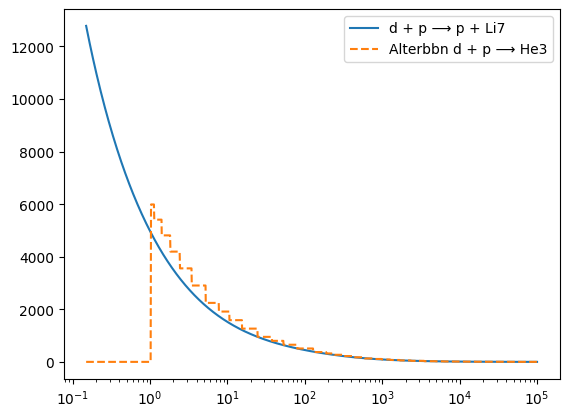

In [14]:
plt.figure()
plt.plot(soltime/timeunit,[Reaclib_d_p__He3(T*TMeV2T9) for T in solY[0]],label='d + p ⟶ p + Li7')
plt.plot(soltime/timeunit,[Alter_d_p__He3(T*TMeV2T9) for T in solY[0]],'--',label='Alterbbn d + p ⟶ He3')

plt.legend()
plt.xscale('log')

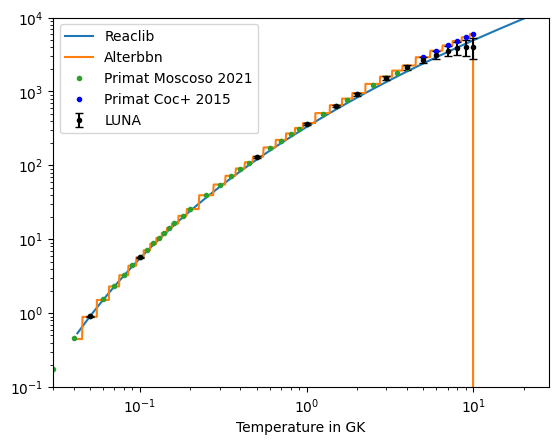

In [15]:
plt.figure()
plt.plot(solY[0]*TMeV2T9,[Reaclib_d_p__He3(T*TMeV2T9) for T in solY[0]],label='Reaclib')
plt.plot(solY[0]*TMeV2T9,[Alter_d_p__He3(T*TMeV2T9) for T in solY[0]],label='Alterbbn')

LUNAdata=np.array([[0.001,1.37e-11,1.35e-11,1.39e-11],[0.005,2.57e-5,2.53e-5,2.62e-5],[0.01,1.53e-3,1.51e-3,1.56e-3],[0.05,9.08e-1,8.94e-1,9.22e-1],[0.1,5.74,5.65,5.84],[0.5,1.29e2,1.26e2,1.32e2],[1.0,3.63e2,3.52e2,3.74e2],[1.5,6.32e2,6.09e2,6.56e2],[2.0,9.20e2,8.79e2,9.62e2],[3.0,1.52e3,1.43e3,1.61e3],[4.0,2.11e3,1.95e3,2.28e3],[5.0,2.67e3,2.40e3,2.93e3],[6.0,3.16e3,2.76e3,3.55e3],[7.0,3.56e3,3.00e3,4.12e3],[8.0,3.85e3,3.09e3,4.61e3],[9.0,4.01e3,3.02e3,5.01e3],[10.0,4.02e3,2.75e3,5.30e3]]).T


T=[0.001,0.005,0.01,0.05,0.1,0.5,1,1.5]+list(range(2,11))
plt.errorbar(LUNAdata[0],LUNAdata[1],yerr=(LUNAdata[1]-LUNAdata[2],LUNAdata[3]-LUNAdata[1]),fmt='k.',label='LUNA',capsize=3)
plt.plot(Primatdata[:-6,0],Primatdata[:-6,1],'.',label='Primat Moscoso 2021')
plt.plot(Primatdata[-6:,0],Primatdata[-6:,1],'.b',label='Primat Coc+ 2015')
plt.xlabel('Temperature in GK')
plt.xlim(0.03)
plt.ylim(1e-1,1e4)
plt.legend()
plt.xscale('log')
plt.yscale('log')

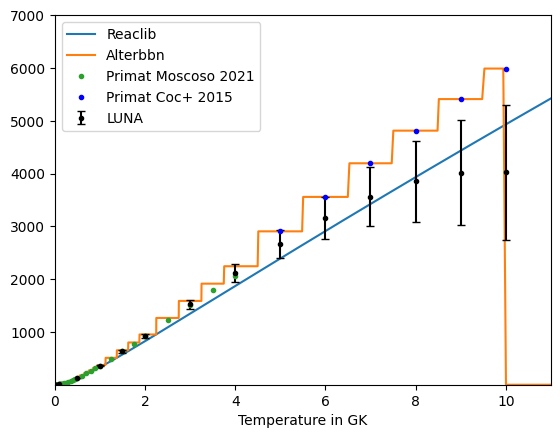

In [16]:
plt.figure()
plt.plot(solY[0]*TMeV2T9,[Reaclib_d_p__He3(T*TMeV2T9) for T in solY[0]],label='Reaclib')
plt.plot(solY[0]*TMeV2T9,[Alter_d_p__He3(T*TMeV2T9) for T in solY[0]],label='Alterbbn')

LUNAdata=np.array([[0.001,1.37e-11,1.35e-11,1.39e-11],[0.005,2.57e-5,2.53e-5,2.62e-5],[0.01,1.53e-3,1.51e-3,1.56e-3],[0.05,9.08e-1,8.94e-1,9.22e-1],[0.1,5.74,5.65,5.84],[0.5,1.29e2,1.26e2,1.32e2],[1.0,3.63e2,3.52e2,3.74e2],[1.5,6.32e2,6.09e2,6.56e2],[2.0,9.20e2,8.79e2,9.62e2],[3.0,1.52e3,1.43e3,1.61e3],[4.0,2.11e3,1.95e3,2.28e3],[5.0,2.67e3,2.40e3,2.93e3],[6.0,3.16e3,2.76e3,3.55e3],[7.0,3.56e3,3.00e3,4.12e3],[8.0,3.85e3,3.09e3,4.61e3],[9.0,4.01e3,3.02e3,5.01e3],[10.0,4.02e3,2.75e3,5.30e3]]).T


T=[0.001,0.005,0.01,0.05,0.1,0.5,1,1.5]+list(range(2,11))
plt.errorbar(LUNAdata[0],LUNAdata[1],yerr=(LUNAdata[1]-LUNAdata[2],LUNAdata[3]-LUNAdata[1]),fmt='k.',label='LUNA',capsize=3)
plt.plot(Primatdata[:-6,0],Primatdata[:-6,1],'.',label='Primat Moscoso 2021')
plt.plot(Primatdata[-6:,0],Primatdata[-6:,1],'.b',label='Primat Coc+ 2015')

plt.xlabel('Temperature in GK')
plt.xlim(0,11)
plt.ylim(1e-1,7000)
plt.legend()



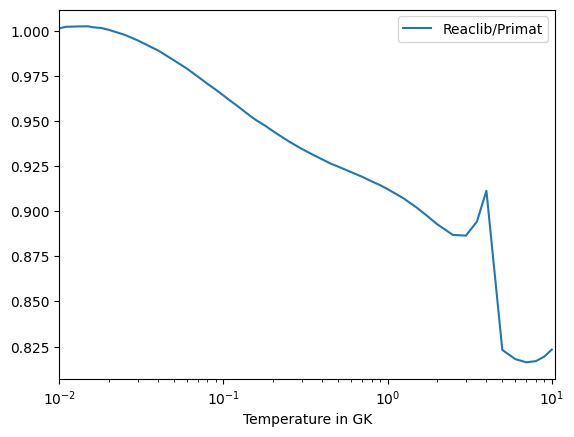

In [18]:
plt.figure()
plt.plot(Primatdata[:,0],Reaclib_d_p__He3(Primatdata[:,0])/Primatdata[:,1],label='Reaclib/Primat')

plt.xlabel('Temperature in GK')

plt.xlim(0.01)


plt.xscale('log')
plt.legend()

In [19]:
intertemps=np.array([1.00e-03, 2.00e-03, 3.00e-03, 4.00e-03, 5.00e-03, 6.00e-03,
       7.00e-03, 8.00e-03, 9.00e-03, 1.00e-02, 1.10e-02, 1.20e-02,
       1.30e-02, 1.40e-02, 1.50e-02, 1.60e-02, 1.80e-02, 2.00e-02,
       2.50e-02, 3.00e-02, 4.00e-02, 5.00e-02, 6.00e-02, 7.00e-02,
       8.00e-02, 9.00e-02, 1.00e-01, 1.10e-01, 1.20e-01, 1.30e-01,
       1.40e-01, 1.50e-01, 1.60e-01, 1.80e-01, 2.00e-01, 2.50e-01,
       3.00e-01, 3.50e-01, 4.00e-01, 4.50e-01, 5.00e-01, 6.00e-01,
       7.00e-01, 8.00e-01, 9.00e-01, 1.00e+00, 1.25e+00, 1.50e+00,
       1.75e+00, 2.00e+00, 2.50e+00, 3.00e+00, 3.50e+00, 4.00e+00,
       5.00e+00, 6.00e+00, 7.00e+00, 8.00e+00, 9.00e+00, 1.00e+01])

interrates=np.array([1.4540e-11, 2.0070e-08, 6.4950e-07, 5.7410e-06, 2.6850e-05,
       8.6660e-05, 2.2020e-04, 4.7430e-04, 9.0580e-04, 1.5800e-03,
       2.5660e-03, 3.9410e-03, 5.7800e-03, 8.1610e-03, 1.1160e-02,
       1.4860e-02, 2.4630e-02, 3.8050e-02, 9.0780e-02, 1.7600e-01,
       4.6120e-01, 9.1540e-01, 1.5450e+00, 2.3500e+00, 3.3250e+00,
       4.4620e+00, 5.7550e+00, 7.1960e+00, 8.7760e+00, 1.0490e+01,
       1.2330e+01, 1.4290e+01, 1.6360e+01, 2.0810e+01, 2.5660e+01,
       3.9270e+01, 5.4670e+01, 7.1550e+01, 8.9680e+01, 1.0890e+02,
       1.2900e+02, 1.7160e+02, 2.1680e+02, 2.6420e+02, 3.1330e+02,
       3.6400e+02, 4.9610e+02, 6.3440e+02, 7.7730e+02, 9.2360e+02,
       1.2210e+03, 1.5160e+03, 1.7960e+03, 2.0500e+03, 2.9050e+03,
       3.5570e+03, 4.1936e+03, 4.8119e+03, 5.4103e+03, 5.9883e+03])

def p_d__he3(T9):


    rate=np.interp(T9,intertemps,interrates)
    return rate

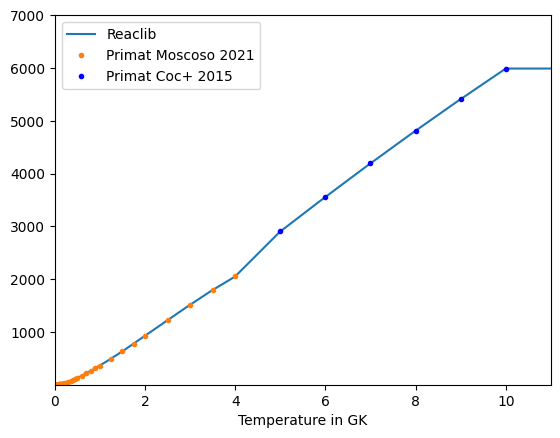

In [20]:
plt.figure()
plt.plot(solY[0]*TMeV2T9,[p_d__he3(T*TMeV2T9) for T in solY[0]],label='Reaclib')


#LUNAdata=np.array([[0.001,1.37e-11,1.35e-11,1.39e-11],[0.005,2.57e-5,2.53e-5,2.62e-5],[0.01,1.53e-3,1.51e-3,1.56e-3],[0.05,9.08e-1,8.94e-1,9.22e-1],[0.1,5.74,5.65,5.84],[0.5,1.29e2,1.26e2,1.32e2],[1.0,3.63e2,3.52e2,3.74e2],[1.5,6.32e2,6.09e2,6.56e2],[2.0,9.20e2,8.79e2,9.62e2],[3.0,1.52e3,1.43e3,1.61e3],[4.0,2.11e3,1.95e3,2.28e3],[5.0,2.67e3,2.40e3,2.93e3],[6.0,3.16e3,2.76e3,3.55e3],[7.0,3.56e3,3.00e3,4.12e3],[8.0,3.85e3,3.09e3,4.61e3],[9.0,4.01e3,3.02e3,5.01e3],[10.0,4.02e3,2.75e3,5.30e3]]).T


T=[0.001,0.005,0.01,0.05,0.1,0.5,1,1.5]+list(range(2,11))
#plt.errorbar(LUNAdata[0],LUNAdata[1],yerr=(LUNAdata[1]-LUNAdata[2],LUNAdata[3]-LUNAdata[1]),fmt='k.',label='LUNA',capsize=3)
plt.plot(Primatdata[:-6,0],Primatdata[:-6,1],'.',label='Primat Moscoso 2021')
plt.plot(Primatdata[-6:,0],Primatdata[-6:,1],'.b',label='Primat Coc+ 2015')


plt.xlabel('Temperature in GK')
plt.xlim(0,11)
plt.ylim(1e-1,7000)
plt.legend()


Text(0, 0.5, 'd converted to He3')

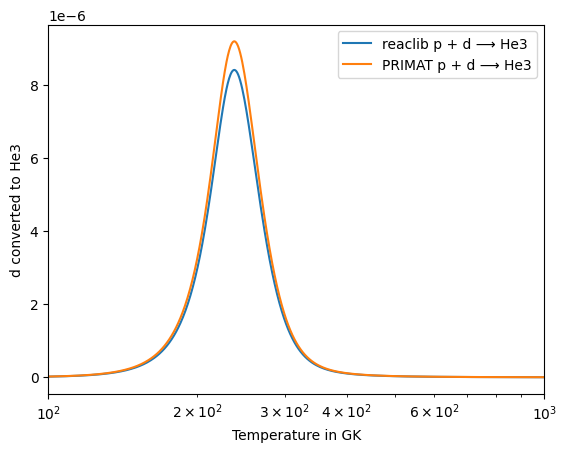

In [62]:
plt.figure()
plt.plot(soltime/timeunit,[Reaclib_d_p__He3(solY[0][i]*TMeV2T9)*solY[3][i]*solY[4][i]*rho_bY_cgs(solY[:,i]) for i in range(len(soltime))],label='reaclib p + d ⟶ He3')
plt.plot(soltime/timeunit,[p_d__he3(solY[0][i]*TMeV2T9)*solY[3][i]*solY[4][i]*rho_bY_cgs(solY[:,i]) for i in range(len(soltime))],label='PRIMAT p + d ⟶ He3')

#plt.axvline(soltime[913]/timeunit)
plt.legend()
plt.xlim(1e2,1e3)
plt.xscale('log')
plt.xlabel('Temperature in GK')
plt.ylabel('d converted to He3')


In [57]:
solY[0][900]*TMeV2T9

2.086774320850178

In [24]:
def he3__p_d(T9):
    rate = 0.0
    T913=T9**(1/3)
    T913i=1/T913
    lnT9=np.log(T9)
    T9i=1/T9
    # de04 
    rate += np.exp(  32.4383 + -63.7435*T9i + -3.7208*T913i + 0.198654*T913
                  + 1.83333*lnT9)
    # de04n
    rate += np.exp(  31.032 + -63.7435*T9i + -3.7208*T913i + 0.871782*T913
                  + 0.833333*lnT9)

    return rate

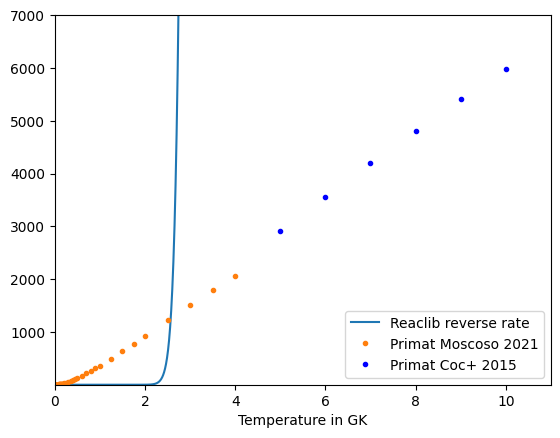

In [50]:
plt.figure()
plt.plot(solY[0]*TMeV2T9,[he3__p_d(T*TMeV2T9) for T in solY[0]],label='Reaclib reverse rate')


#LUNAdata=np.array([[0.001,1.37e-11,1.35e-11,1.39e-11],[0.005,2.57e-5,2.53e-5,2.62e-5],[0.01,1.53e-3,1.51e-3,1.56e-3],[0.05,9.08e-1,8.94e-1,9.22e-1],[0.1,5.74,5.65,5.84],[0.5,1.29e2,1.26e2,1.32e2],[1.0,3.63e2,3.52e2,3.74e2],[1.5,6.32e2,6.09e2,6.56e2],[2.0,9.20e2,8.79e2,9.62e2],[3.0,1.52e3,1.43e3,1.61e3],[4.0,2.11e3,1.95e3,2.28e3],[5.0,2.67e3,2.40e3,2.93e3],[6.0,3.16e3,2.76e3,3.55e3],[7.0,3.56e3,3.00e3,4.12e3],[8.0,3.85e3,3.09e3,4.61e3],[9.0,4.01e3,3.02e3,5.01e3],[10.0,4.02e3,2.75e3,5.30e3]]).T


T=[0.001,0.005,0.01,0.05,0.1,0.5,1,1.5]+list(range(2,11))
#plt.errorbar(LUNAdata[0],LUNAdata[1],yerr=(LUNAdata[1]-LUNAdata[2],LUNAdata[3]-LUNAdata[1]),fmt='k.',label='LUNA',capsize=3)
plt.plot(Primatdata[:-6,0],Primatdata[:-6,1],'.',label='Primat Moscoso 2021')
plt.plot(Primatdata[-6:,0],Primatdata[-6:,1],'.b',label='Primat Coc+ 2015')


plt.xlabel('Temperature in GK')
plt.xlim(0,11)
plt.ylim(1e-1,7000)
plt.legend()
